In [1]:
import pandas as pd
import datetime
import numpy as np
from sentence_transformers import SentenceTransformer
import umap
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_distances


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [3]:
class RatingUserFilter:
    def __init__(self, min_ratings_per_user):
        self.min_ratings_per_user = min_ratings_per_user

    def __call__(self, loader):
        # First filter out users who gave <= 1 ratings
        loader.ratings_df = loader.ratings_df[loader.ratings_df['userId'].map(loader.ratings_df['userId'].value_counts()) >= self.min_ratings_per_user]
        loader.ratings_df = loader.ratings_df.reset_index(drop=True)
        print(f"Ratings shape after user filtering: {loader.ratings_df.shape}, n_users = {loader.ratings_df.userId.unique().size}, n_items = {loader.ratings_df.movieId.unique().size}")
        
# Filters out all low ratings
class RatingLowFilter:
    def __init__(self, min_rating):
        self.min_rating = min_rating
    def __call__(self, loader):
        loader.ratings_df = loader.ratings_df[loader.ratings_df.rating >= self.min_rating]
        loader.ratings_df = loader.ratings_df.reset_index(drop=True)

class RatedMovieFilter:
    def __call__(self, loader):
        # We are only interested in movies for which we have ratings
        rated_movie_ids = loader.ratings_df.movieId.unique()

        loader.movies_df = loader.movies_df[loader.movies_df.movieId.isin(rated_movie_ids)]
        loader.movies_df = loader.movies_df.reset_index(drop=True)

        # Filter also their embeddings
        loader.embeddings_df = loader.embeddings_df[loader.embeddings_df.movieId.isin(rated_movie_ids)]
        loader.embeddings_df = loader.embeddings_df.reset_index(drop=True)

# Filters out all ratings of movies that do not have enough ratings per year
class RatingsPerYearFilter:
    def __init__(self, min_ratings_per_year):
        self.min_ratings_per_year = min_ratings_per_year

    def __call__(self, loader):
        movies_df_indexed = loader.movies_df.set_index("movieId")

        # Add column with age of each movie
        movies_df_indexed.loc[:, "age"] = movies_df_indexed.year.max() - movies_df_indexed.year
        
        # Calculate number of ratings per year for each of the movies
        loader.ratings_df.loc[:, "ratings_per_year"] = loader.ratings_df['movieId'].map(loader.ratings_df['movieId'].value_counts()) / loader.ratings_df['movieId'].map(movies_df_indexed["age"])
        
        # Filter out movies that do not have enough yearly ratings
        loader.ratings_df = loader.ratings_df[loader.ratings_df.ratings_per_year >= self.min_ratings_per_year]

class MovieFilterByYear:
    def __init__(self, min_year):
        self.min_year = min_year
        
    def _parse_year(self, x):
        x = x.split("(")
        if len(x) <= 1:
            return 0
        try:
            return int(x[-1].split(")")[0])
        except:
            return 0

    def __call__(self, loader):
        # Filter out unrated movies and old movies
        # Add year column      
        loader.movies_df.loc[:, "year"] = loader.movies_df.title.apply(self._parse_year)
        loader.movies_df = loader.movies_df[loader.movies_df.year >= self.min_year]
        loader.movies_df = loader.movies_df.reset_index(drop=True)

class RatingFilterOld:
    def __init__(self, oldest_rating_year):
        self.oldest_rating_year = oldest_rating_year
    def __call__(self, loader):
        # Marker for oldest rating
        oldest_rating = datetime.datetime(year=self.oldest_rating_year, month=1, day=1, tzinfo=datetime.timezone.utc).timestamp()
        # Filter ratings that are too old
        loader.ratings_df = loader.ratings_df[loader.ratings_df.timestamp > oldest_rating]
        #loader.ratings_df = loader.ratings_df.reset_index(drop=True)

class LinkFilter:
    def __call__(self, loader):
        loader.links_df = loader.links_df[loader.links_df.index.isin((loader.movies_df.movieId))]

In [4]:
# Dummy loader to simulate the object used in filters
class Loader:
    def __init__(self, movies_df, ratings_df, links_df, embeddings_df=None):
        self.movies_df = movies_df[movies_df['plot'] != 'X']
        self.ratings_df = ratings_df
        self.links_df = links_df
        self.embeddings_df = embeddings_df if embeddings_df is not None else pd.DataFrame(columns=["movieId"])

# Define filters exactly as described (reusing your implementations)
# [Assume all class definitions provided by you are defined here]

# Read CSV files
movies_df = pd.read_csv("movies.csv")
ratings_df = pd.read_csv("ratings.csv")
links_df = pd.read_csv("links.csv")

# Initialize loader
loader = Loader(movies_df, ratings_df, links_df)

# Instantiate filters
filters = [
    RatingLowFilter(4.0),
    MovieFilterByYear(1990),
    RatingFilterOld(2010),
    RatingsPerYearFilter(50.0),
    RatingUserFilter(100),
    RatedMovieFilter(),
    LinkFilter()
]

# Apply filters
for f in filters:
    f(loader)

# Now get genres value counts for movies where plot != "X"
filtered_movies = loader.movies_df
print(len(filtered_movies))

# Print value counts of the genres column
print(filtered_movies['genres'].value_counts())


C:\Users\richa\AppData\Local\Temp\ipykernel_32348\2249556646.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  loader.movies_df.loc[:, "year"] = loader.movies_df.title.apply(self._parse_year)


Ratings shape after user filtering: (2644242, 5), n_users = 15365, n_items = 2038
2038
genres
Drama                                207
Comedy                               116
Comedy|Drama                          85
Documentary                           80
Drama|Romance                         57
                                    ... 
Action|Comedy|Fantasy                  1
Comedy|Mystery                         1
Adventure|Mystery|Thriller             1
Adventure|Animation|Drama|Fantasy      1
Animation|Children|Drama|Fantasy       1
Name: count, Length: 456, dtype: int64


In [5]:
filtered_movies["genres"] = filtered_movies["genres"].str.replace("|", ", ", regex=False)
print(filtered_movies.iloc[0])

movieId                                                    1
title                                       Toy Story (1995)
genres       Adventure, Animation, Children, Comedy, Fantasy
plot       A cowboy doll is profoundly threatened and jea...
year                                                    1995
Name: 0, dtype: object


In [6]:
print((filtered_movies[['genres', 'plot']].map(lambda x: x.strip() == '')).sum())

genres    0
plot      0
dtype: int64


In [7]:
genre_strings = ["Genres of the movie: " + genres for genres in filtered_movies["genres"]]

# Encode the genres using the SentenceTransformer model
genres_embeddings = model.encode(genre_strings, show_progress_bar=True)


plot_strings = ["Plot of the movie: " + plot for plot in filtered_movies["plot"]]

plot_embeddings = model.encode(plot_strings, show_progress_bar=True)

# Save to .npy files
np.save('genres_embeddings.npy', genres_embeddings)
np.save('plot_embeddings.npy', plot_embeddings)

print("Embeddings saved to 'genres_embeddings.npy' and 'plot_embeddings.npy'")

Batches: 100%|██████████| 64/64 [00:10<00:00,  6.03it/s]

Embeddings saved to 'genres_embeddings.npy' and 'plot_embeddings.npy'


c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


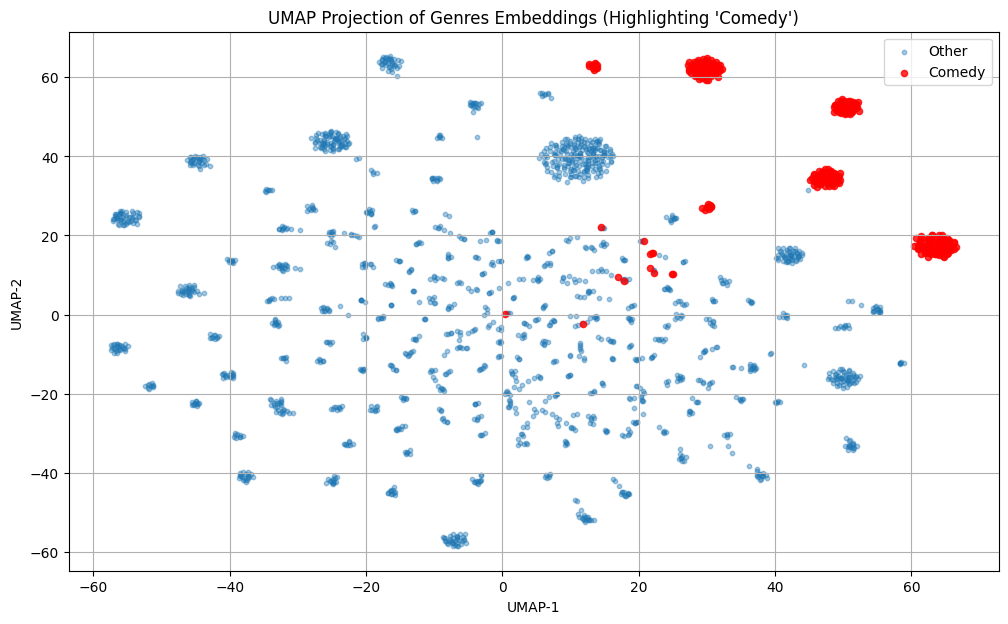

In [8]:
genres_embeddings = np.load('genres_embeddings.npy')

umap_genres = umap.UMAP(
    n_neighbors=3,
    n_components=2,
    random_state=42, 
    metric="cosine",
    min_dist=0.5,
    spread=15)
genres_2d = umap_genres.fit_transform(genres_embeddings)

single_comedy_mask = filtered_movies['genres'].str.lower().str.split(',').apply(lambda x: len(x) == 1 and 'comedy' in x)

# Mask for movies with exactly 2 genres, and one of them is "Comedy"
two_genre_comedy_mask = filtered_movies['genres'].str.lower().str.split(',').apply(lambda x: len(x) == 2 and 'comedy' in x)

comedy_movies_mask = single_comedy_mask | two_genre_comedy_mask

plt.figure(figsize=(12, 7))
plt.scatter(genres_2d[~comedy_movies_mask, 0], genres_2d[~comedy_movies_mask, 1], s=10, alpha=0.4, label='Other')
plt.scatter(genres_2d[comedy_movies_mask, 0], genres_2d[comedy_movies_mask, 1], s=20, color='red', alpha=0.8, label='Comedy')
plt.title("UMAP Projection of Genres Embeddings (Highlighting 'Comedy')")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.show()

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


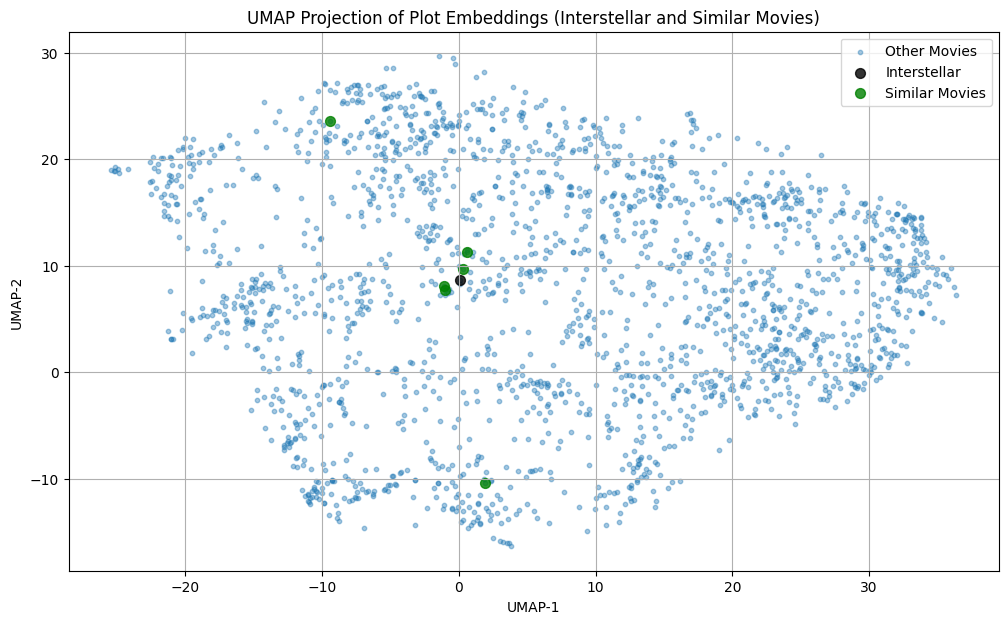

Similar Movies:
Cars (2006)
Icarus (2017)
Running with Speed (2023)
The Deepest Breath (2023)
Fast and the Furious, The (2001)
Rally Road Racers (2023)


In [9]:
plot_embeddings = np.load('plot_embeddings.npy')

umap_plot = umap.UMAP(
    n_neighbors=20,
    n_components=5,
    random_state=42,
    metric="cosine",
    min_dist=0.5,
    spread=15)
plot_2d = umap_plot.fit_transform(plot_embeddings)

index = filtered_movies[filtered_movies['title'] == "Gran Turismo (2023)"].index[0]

selected_movie_embedding = plot_embeddings[index]

distances = cosine_distances([selected_movie_embedding], plot_embeddings).flatten()

nearest_indices = np.argsort(distances)[1:7]  # Skip the first one

plt.figure(figsize=(12, 7))

plt.scatter(plot_2d[:, 0], plot_2d[:, 1], s=10, alpha=0.4, label="Other Movies")

plt.scatter(plot_2d[index, 0], plot_2d[index, 1], s=50, color="black", alpha=0.8, label="Interstellar")

plt.scatter(plot_2d[nearest_indices, 0], plot_2d[nearest_indices, 1], s=50, color="green", alpha=0.8, label="Similar Movies")

plt.title("UMAP Projection of Plot Embeddings (Interstellar and Similar Movies)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.show()

print("Similar Movies:")
for idx in nearest_indices:
    print(filtered_movies.iloc[idx]["title"])

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


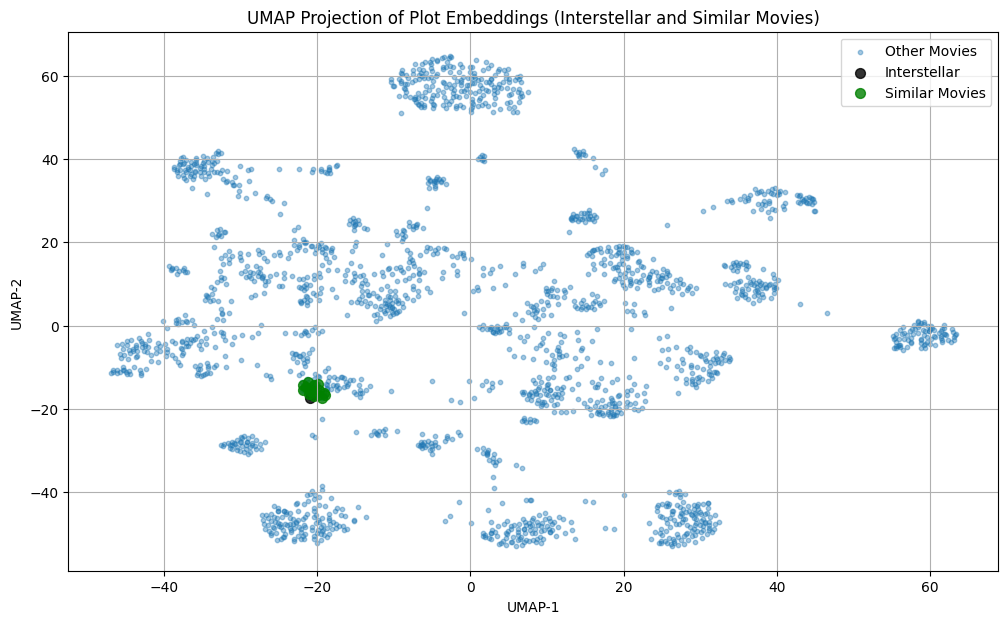

In [10]:

umap_genres = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    random_state=42, 
    metric="cosine",
    min_dist=0.3,
    spread=15)

final_embeddings = (1.4 * genres_embeddings + 0.8 * plot_embeddings) 

coords_2d = umap_genres.fit_transform(final_embeddings)

index = filtered_movies[filtered_movies['title'] == "Interstellar (2014)"].index[0]

selected_movie_embedding = final_embeddings[index]

distances = cosine_distances([selected_movie_embedding], final_embeddings).flatten()

nearest_indices = np.argsort(distances)[1:16]  # Skip the first one

plt.figure(figsize=(12, 7))

plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=10, alpha=0.4, label="Other Movies")

plt.scatter(coords_2d[index, 0], coords_2d[index, 1], s=50, color="black", alpha=0.8, label="Interstellar")

plt.scatter(coords_2d[nearest_indices, 0], coords_2d[nearest_indices, 1], s=50, color="green", alpha=0.8, label="Similar Movies")

plt.title("UMAP Projection of Plot Embeddings (Interstellar and Similar Movies)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.show()

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


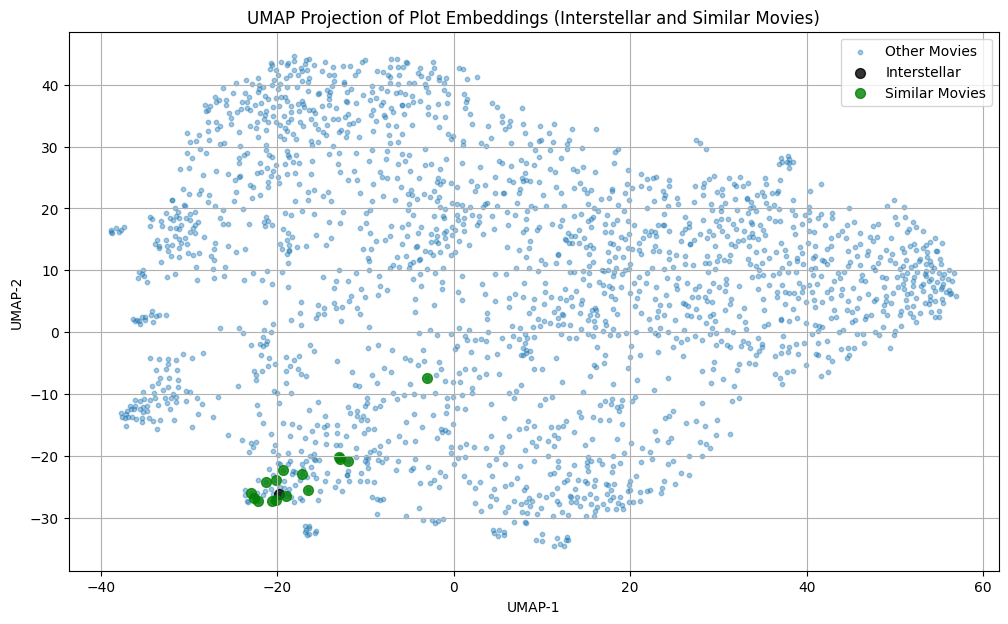

In [11]:

umap_genres = umap.UMAP(
    n_neighbors=20,
    n_components=2,
    random_state=42, 
    metric="cosine",
    min_dist=0.3,
    spread=15)

final_embeddings = (0.8 * genres_embeddings + 1.4 * plot_embeddings) 

coords_2d = umap_genres.fit_transform(final_embeddings)

index = filtered_movies[filtered_movies['title'] == "Interstellar (2014)"].index[0]

selected_movie_embedding = final_embeddings[index]

distances = cosine_distances([selected_movie_embedding], final_embeddings).flatten()

nearest_indices = np.argsort(distances)[1:16]  # Skip the first one

plt.figure(figsize=(12, 7))

plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=10, alpha=0.4, label="Other Movies")

plt.scatter(coords_2d[index, 0], coords_2d[index, 1], s=50, color="black", alpha=0.8, label="Interstellar")

plt.scatter(coords_2d[nearest_indices, 0], coords_2d[nearest_indices, 1], s=50, color="green", alpha=0.8, label="Similar Movies")

plt.title("UMAP Projection of Plot Embeddings (Interstellar and Similar Movies)")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.legend()
plt.grid(True)
plt.show()

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


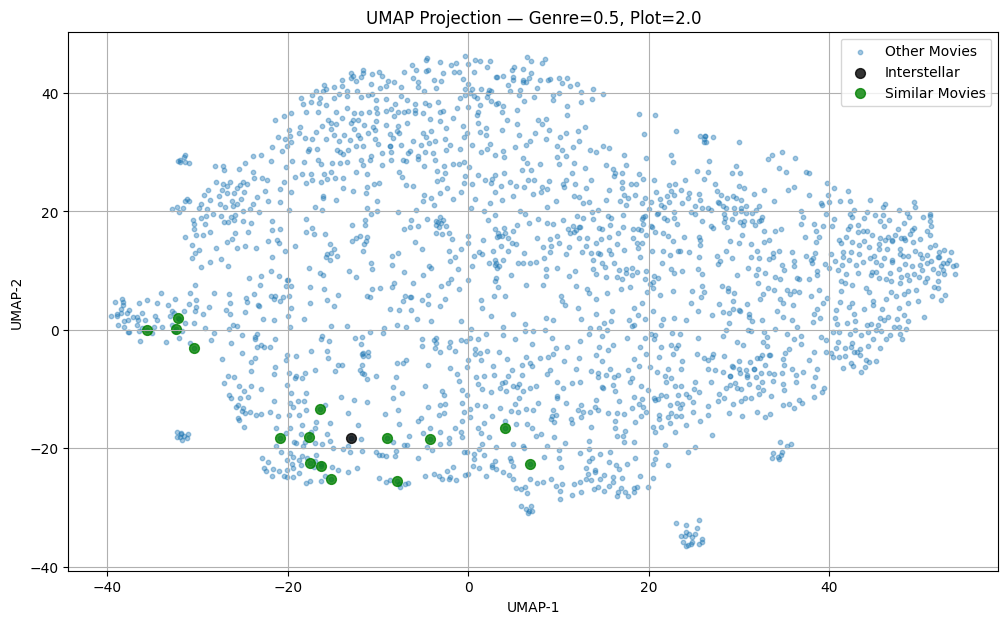

Pacific Rim (2013)     Action, Adventure, Sci-Fi, IMA   As a war between humankind and monstrous sea creatures wages on, a former pilot 

Similar Movies (Genre=0.5, Plot=2.0):
Meg 2: The Trench (2   Action, Comedy, Horror, Sci-Fi   A research team's journey into the depths of the ocean turns into chaos when a m
Resident Evil (2002)   Action, Horror, Sci-Fi, Thrill   A special military unit fights a powerful, out-of-control supercomputer and hund
The Sea Beast (2022)   Adventure, Animation, Children   When a young girl stows away on the ship of a legendary sea monster hunter, they
Master and Commander   Adventure, Drama, War            During the Napoleonic Wars, a brash British captain pushes his ship and crew to 
Greyhound (2020)       War                              Several months after the U.S. entry into World War II, an inexperienced U.S. Nav
Jarhead (2005)         Action, Drama, War               A psychological study of Marine's state of mind during the Gulf War. Told throug
Tr

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


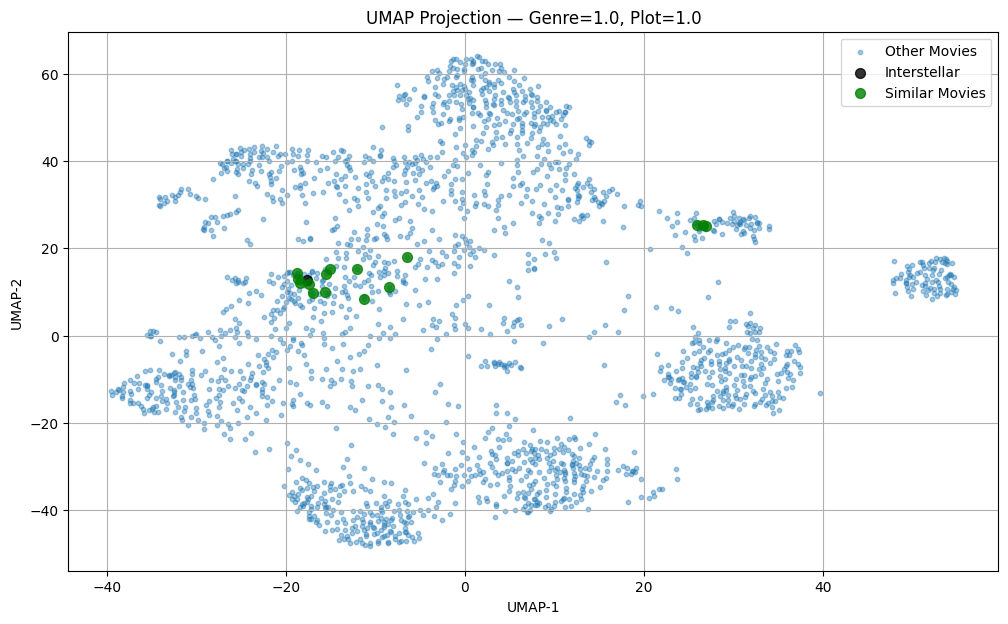

Pacific Rim (2013)     Action, Adventure, Sci-Fi, IMA   As a war between humankind and monstrous sea creatures wages on, a former pilot 

Similar Movies (Genre=1.0, Plot=1.0):
John Carter (2012)     Action, Adventure, Sci-Fi, IMA   A war-weary former army captain is inexplicably transported to Mars and reluctan
Avatar (2009)          Action, Adventure, Sci-Fi, IMA   A paraplegic Marine dispatched to the moon Pandora on a unique mission becomes t
Meg 2: The Trench (2   Action, Comedy, Horror, Sci-Fi   A research team's journey into the depths of the ocean turns into chaos when a m
Godzilla (2014)        Action, Adventure, Sci-Fi, IMA   The world is beset by the appearance of monstrous creatures, but one of them may
Star Trek Into Darkn   Action, Adventure, Sci-Fi, IMA   After the crew of the Enterprise find an unstoppable force of terror from within
Star Trek Beyond (20   Action, Adventure, Sci-Fi        The crew of the USS Enterprise explores the furthest reaches of uncharted space,
In

c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\richa\Desktop\SCHOOL\mgr\diplomka\experiment\EasyStudy\server\venv\lib\site-packages\umap\umap_.py:1401: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


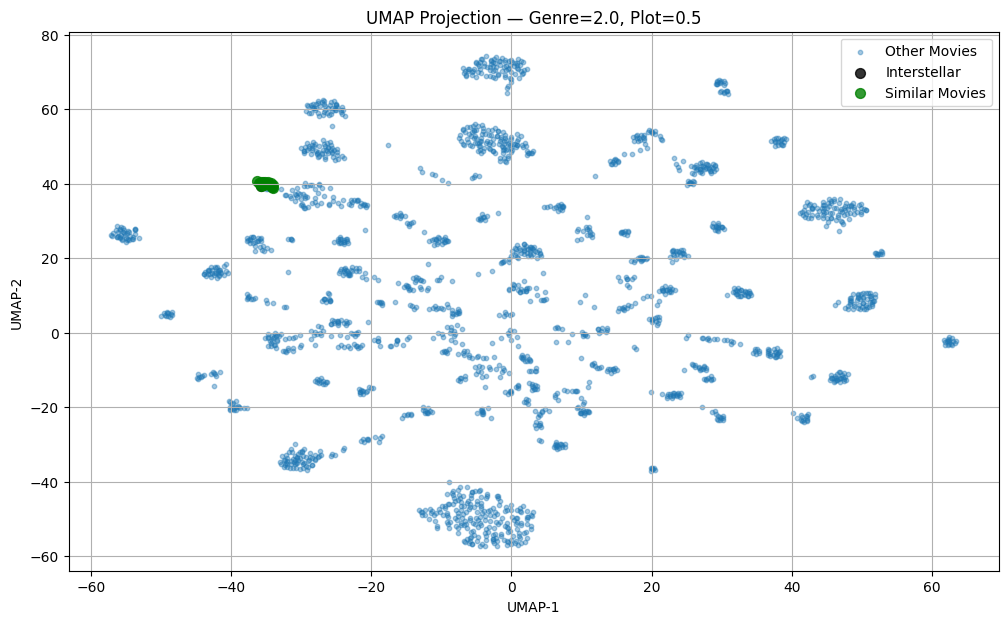

Pacific Rim (2013)     Action, Adventure, Sci-Fi, IMA   As a war between humankind and monstrous sea creatures wages on, a former pilot 

Similar Movies (Genre=2.0, Plot=0.5):
John Carter (2012)     Action, Adventure, Sci-Fi, IMA   A war-weary former army captain is inexplicably transported to Mars and reluctan
Avatar (2009)          Action, Adventure, Sci-Fi, IMA   A paraplegic Marine dispatched to the moon Pandora on a unique mission becomes t
Godzilla (2014)        Action, Adventure, Sci-Fi, IMA   The world is beset by the appearance of monstrous creatures, but one of them may
Star Trek Into Darkn   Action, Adventure, Sci-Fi, IMA   After the crew of the Enterprise find an unstoppable force of terror from within
Oblivion (2013)        Action, Adventure, Sci-Fi, IMA   Jack Harper, a drone repairman stationed on Earth that has been ravaged by war w
Ender's Game (2013)    Action, Adventure, Sci-Fi, IMA   Young Ender Wiggin is recruited by the International Military to lead the fight 
Ca

In [ ]:
weight_combinations = [
    (0.5, 2.0),
    (1.0, 1.0),
    (2.0, 0.5)
]

for genre_weight, plot_weight in weight_combinations:
    final_embeddings = genre_weight * genres_embeddings + plot_weight * plot_embeddings
    coords_2d = umap_genres.fit_transform(final_embeddings)

    index = filtered_movies[filtered_movies['title'] == "Pacific Rim (2013)"].index[0] # Interstellar (2014)
    selected_movie_embedding = final_embeddings[index]

    distances = cosine_distances([selected_movie_embedding], final_embeddings).flatten()
    nearest_indices = np.argsort(distances)[1:16]

    # Plot
    plt.figure(figsize=(12, 7))
    plt.scatter(coords_2d[:, 0], coords_2d[:, 1], s=10, alpha=0.4, label="Other Movies")
    plt.scatter(coords_2d[index, 0], coords_2d[index, 1], s=50, color="black", alpha=0.8, label="Interstellar")
    plt.scatter(coords_2d[nearest_indices, 0], coords_2d[nearest_indices, 1], s=50, color="green", alpha=0.8, label="Similar Movies")

    plt.title(f"UMAP Projection — Genre={genre_weight}, Plot={plot_weight}")
    plt.xlabel("UMAP-1")
    plt.ylabel("UMAP-2")
    plt.legend()
    plt.grid(True)
    plt.show()

    selected_movie = filtered_movies.iloc[index]
    title = selected_movie["title"][:20]
    genres = selected_movie["genres"][:30]
    plot = selected_movie["plot"][:80]
    print(f"{title:<22} {genres:<32} {plot}")

    print(f"\nSimilar Movies (Genre={genre_weight}, Plot={plot_weight}):")
    for idx in nearest_indices:
        movie = filtered_movies.iloc[idx]
        title = movie["title"][:20]
        genres = movie["genres"][:30]
        plot = movie["plot"][:80]

        print(f"{title:<22} {genres:<32} {plot}")
